# Model Intepretability

L'intepretazione di un modello ottenuto tramite ML si divide in due parti: quella in cui ci si occupa di comprendere quanto ogni feature (colonna o dimensione) influenzi il modello, e quella che decodifica l'output di un singolo sample (riga o istanza).

## White/Black box

Quando costruiamo un modello con ML possiamo scegliere tra diversi algoritmi. Alcuni di essi generano modelli che possiamo facilmente intepretare da soli, ma la maggior parte degli algoritmi più avanzati producono quelli che vengono definiti Black Box: modelli la cui comprensione del funzionamento interno ci è inaccessibile.

## White box

In molti casi ci è possibile ottenere modelli performanti già utilizzando algoritmi che generino white box. In questo caso l'effetto delle feature su una predizione (o una classificazione) é semplice da intepretare. Ad esempio nel caso della Linear Regression, abbiamo i coefficienti delle singole features che rappresentano matematicamente quanto ognuna influenzi la previsione finale. Un decision tree è anch'esso facilmente interpretabile, in quanto ad ogni bivio sappiamo intepretare le ragioni della scelta.

## Black box

Gli algoritmi più complessi di ML generano modelli più complessi, impossibili da intepretare. In una semplice neural network, per quanto si possa avere di fronte il valore dei pesi e dei bias di ogni nodo, non è possibile comprendere come ogni feature possa riflettersi nell'output del modello. La stessa cosa vale anche per una random forest, in cui la struttura dei singoli alberi può anche essere nota, ma non consente di comprendere il risultato della classificazione finale.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lime
import shap
import xgboost
import warnings
import os
import json
from skimage import io, color, transform
from plot_nn import draw_neural_net

warnings.filterwarnings('ignore')
shap.initjs()
%matplotlib inline

## White box

Due esempi di white box: classificazione su dataset dei fiori (iris) a partire da 4 features e linear regression sui prezzi su dataset di pazienti diabetici.

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

iris_df = sns.load_dataset('iris')
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
iris_df.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [4]:
iris_white_model = DecisionTreeClassifier(max_depth=4)
X_iris = iris_df.drop(['species'], axis=1)
y_iris = iris_df[['species']]

iris_white_model.fit(X_iris, y_iris)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

0.9933333333333333

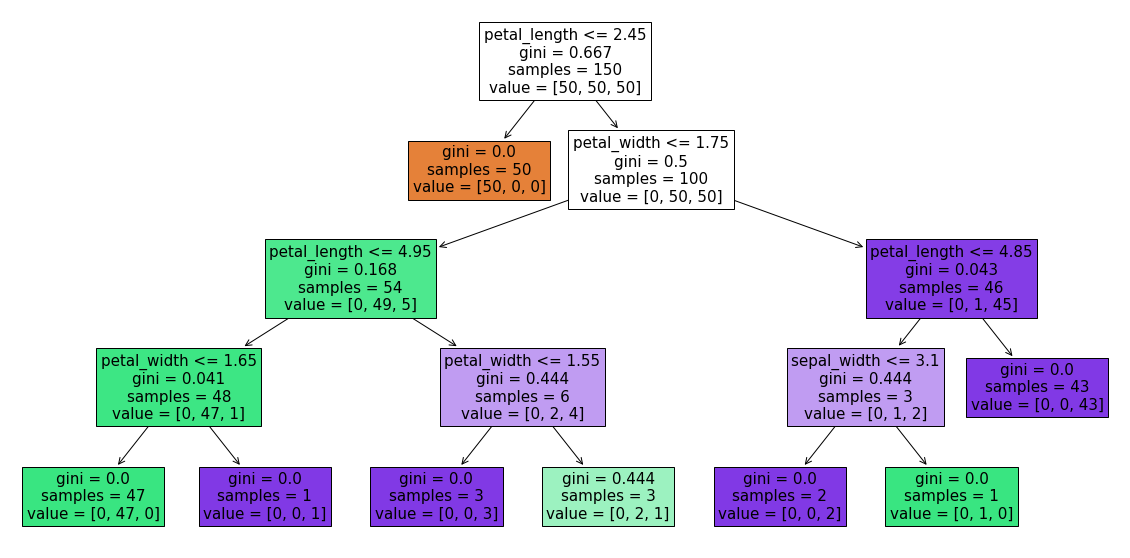

In [5]:
fig = plt.figure(figsize=(20,10))
plotted = plot_tree(iris_white_model, feature_names=X_iris.columns, filled=True)
iris_white_model.score(X_iris, y_iris)

Possiamo facilmente seguire come qualsiasi predizione fatta su un sample sia stata ottenuta semplicemente seguendo il decision tree. Questo ci consente sia di validare la classificazione alla luce di quello che sappiamo, sia di individuare bias nel modello, sia infine di imparare le regole interne del modello stesso.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA

diab_raw = load_diabetes()
diab_df = pd.DataFrame(data=np.c_[diab_raw['data'], diab_raw['target']], columns=diab_raw['feature_names'] + ['target'])

diab_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [7]:
diab_white_model = LinearRegression()
diab_pc = PCA(1)

X_diab = diab_df.drop(['target'], axis=1)
y_diab = diab_df['target']
reduced = diab_pc.fit_transform(X_diab)

diab_white_model.fit(X_diab, y_diab)
diab_white_model.score(X_diab, y_diab)

0.5177494254132934

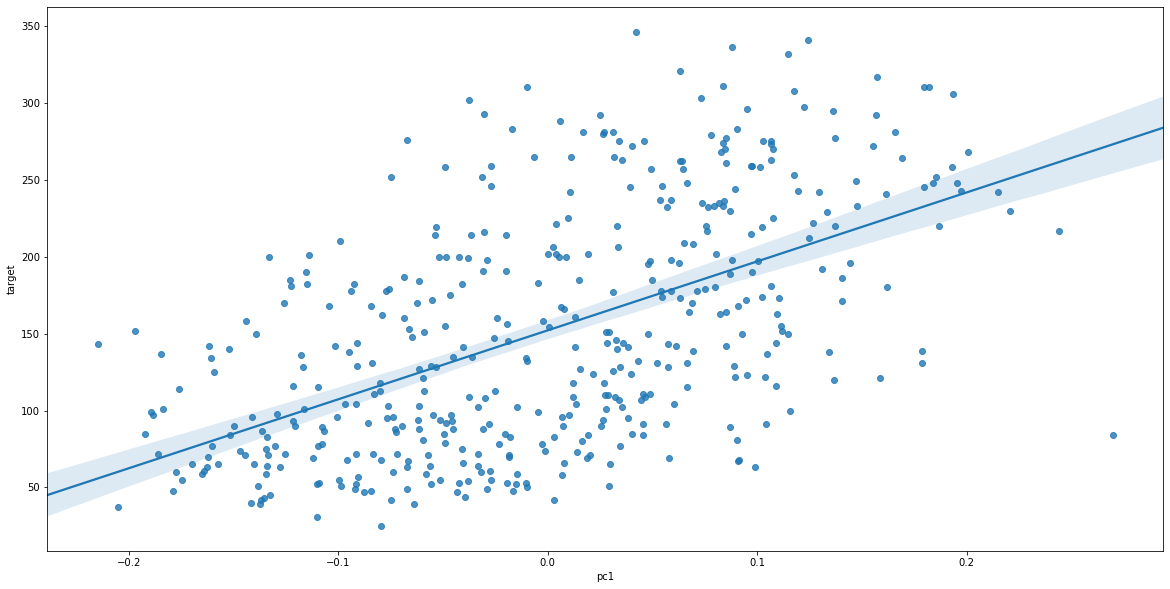

In [8]:
fig = plt.figure(figsize=(20,10))
diab_data = pd.DataFrame()
diab_data['pc1'] = reduced.ravel()
diab_data['target'] = y_diab
sns.regplot(x='pc1', y='target', data=diab_data)

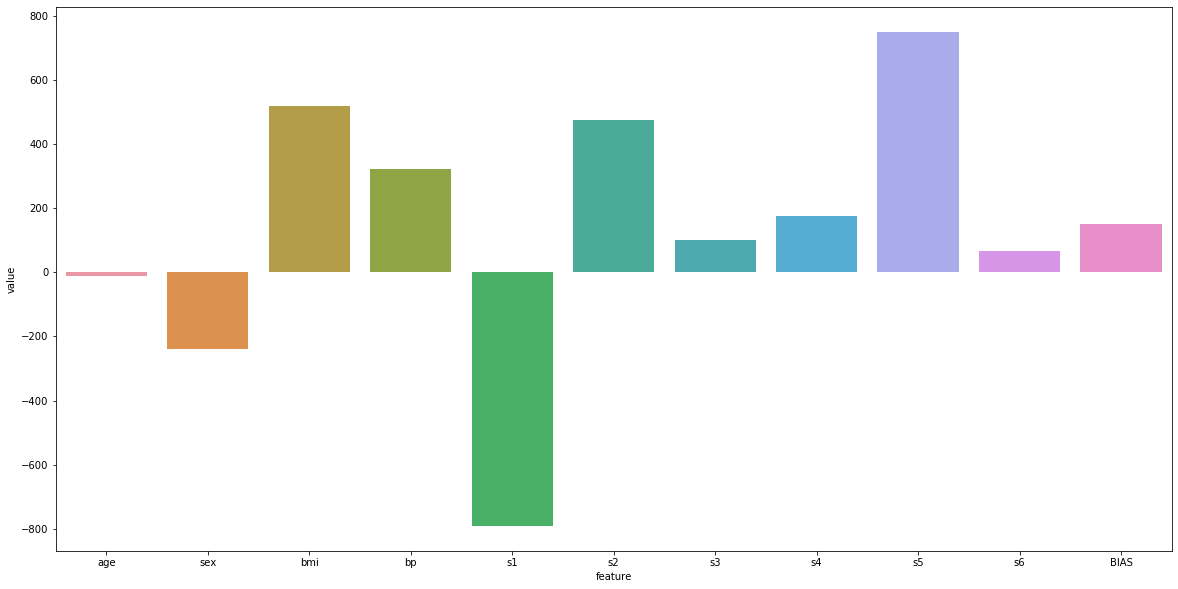

In [9]:
bar_values = diab_white_model.coef_.tolist() + [diab_white_model.intercept_]
bar_names = X_diab.columns.tolist() + ['BIAS']
diab_data = pd.DataFrame()
diab_data['feature'] = bar_names
diab_data['value'] = bar_values

fig = plt.figure(figsize=(20,10))
sns.barplot(x='feature', y='value', data=diab_data)

## Black box

Un esempio di black box: neural network per la predizione del prezzo di una casa a boston.

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

layers = (8, 20, 4)

model = MLPClassifier(hidden_layer_sizes=layers, random_state=200518, solver='lbfgs', alpha=1e-1,)

model.fit(X_iris, y_iris.values.ravel())
model.score(X_iris, y_iris.values.ravel())

0.9866666666666667

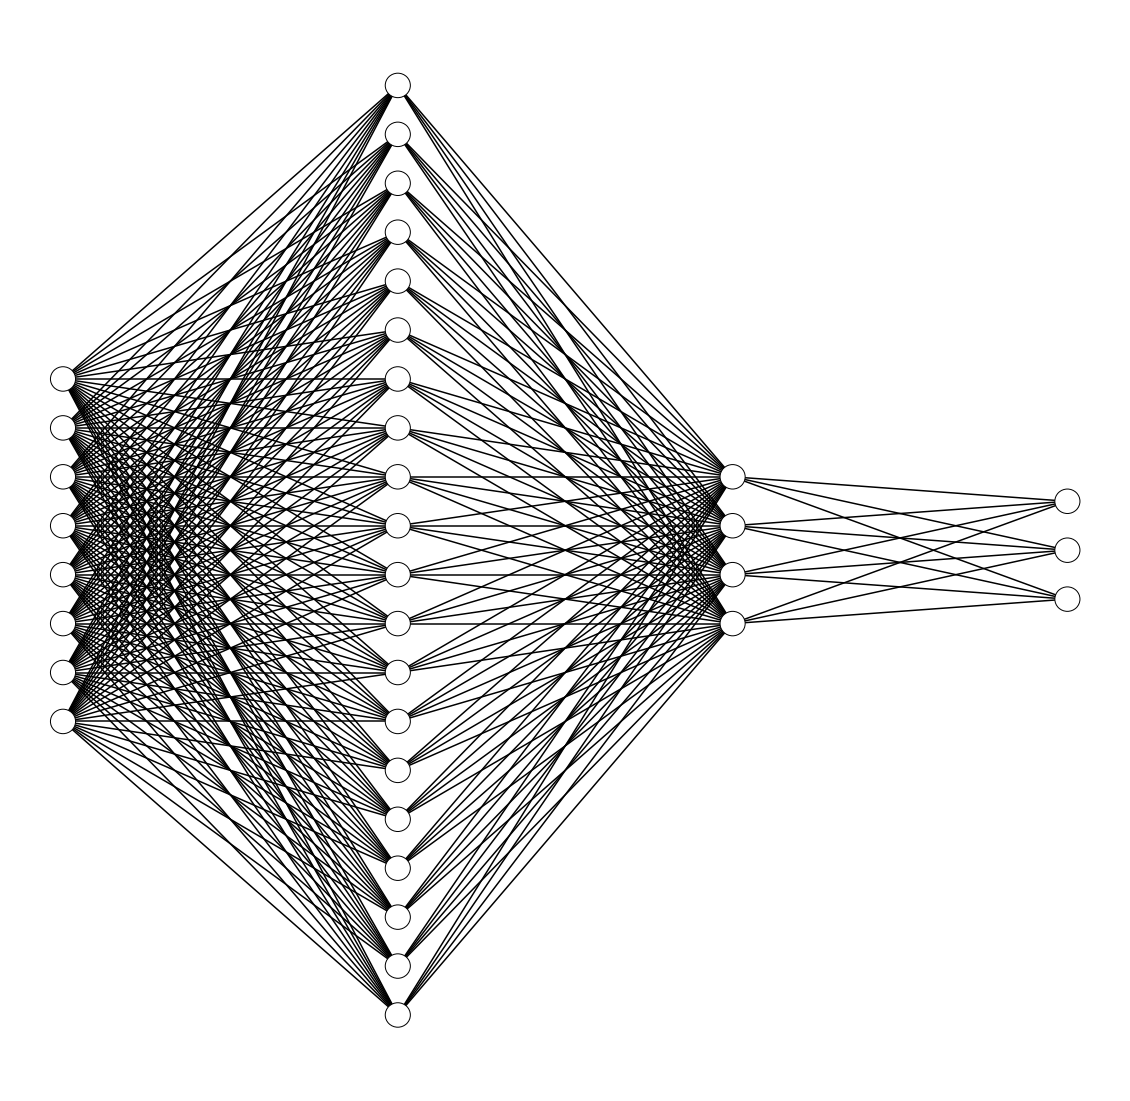

In [11]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .05, .95, .05, .95, [len(b) for b in model.intercepts_])

In questo caso, una neural network di piccole dimensioni, ci sarebbe molto difficile capire come ogni nodo, peso e bias influenzi la classificazione finale.

## Some python magic!

Ora possiamo provare a vedere come funzionano alcune librerie che ci aiutano a capire il funzionamento dei modelli black box.

### Partial dependency plot

Una volta che il modello è stato costruito, vengono calcolati i valori di dipendenza parziale tra l'output e le singole features. Questo si esegue generando input in cui l'unico valore che cambia è una singola dimensione, cercando quindi di isolare l'effetto della stessa. In caso di interdipendenza tra dimensioni (correlazione) questi valori peró perdono di significato.

### Lime

Questa libreria si basa su un algoritmo che ci permette di capire le ragioni dietro l'output di una singola istanza. Lo fa cercando di approssimare il modello black box nell'intorno dell'istanza ad un modello white box, e quindi interpretabile.
Grazie al suo funzionamento, si puó applicare a qualsiasi modello, anche uno sul quale non si abbia alcun controllo tranne input ed output.

### Shap

Anche questa libreria si basa su un algoritmo che ci permette di capire le ragioni dietro l'output di una singola istanza e l'importanza delle features su un modello. Lo fa calcolando l'output di un'istanza, e quindi ricalcolandolo diverse volte rimuovendo una feature alla volta e considerando i delta dei nuovi output rispetto all'originale come effetto della feature rimossa. Poichè SHAP usa diversi algoritmi sotto, anche Lime è implementato tra quelli a disposizione.

## Shap

Vediamo l'applicazione di Shap nella predizione del dataset delle case di Boston. In questo dataset cerchiamo di prevedere il valore di una casa noti alcuni parametri relativi alla casa o alla zona in cui è situata. Per farlo usiamo una NN, quindi un black box.
Dopo aver effettuato il training del modello, genereremo un explainer con Shap, e lo useremo per ottenere una spiegazione su una singola predizione e sull'importanza delle features in generale.

In [12]:
df_boston = shap.datasets.boston()[0]
df_boston['HOUSE_VALUE'] = shap.datasets.boston()[1]

df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,HOUSE_VALUE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
X_boston = df_boston.drop(['HOUSE_VALUE'], axis=1)
y_boston = df_boston[['HOUSE_VALUE']]
boston_black_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_boston, label=y_boston), 100)
explainer = shap.TreeExplainer(boston_black_model)
shap_values = explainer.shap_values(X_boston)

In [14]:
sample_idx = 30
shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], X_boston.iloc[sample_idx,:])

Questo è un force plot, nel quale si può vedere il base value (14.23), ovvero il valore che il modello restituisce come output partendo da un input vuoto, e il valore di output (9.40). Per ottenere l'output vediamo come ogni feature concorra a spostare il risultato finale partendo dalla base, ognuna con una sua direzione ed un suo modulo.

In [15]:
shap.force_plot(explainer.expected_value, shap_values[0:,], X_boston.iloc[0:,])

Questa invece è semplicemente una raccolta di force plot ruotati in verticale: ogni colonna è di fatto un sample di cui è stato computato il force plot. Ci permette di intuire quali siano le features più importanti per la maggior parte dei samples.

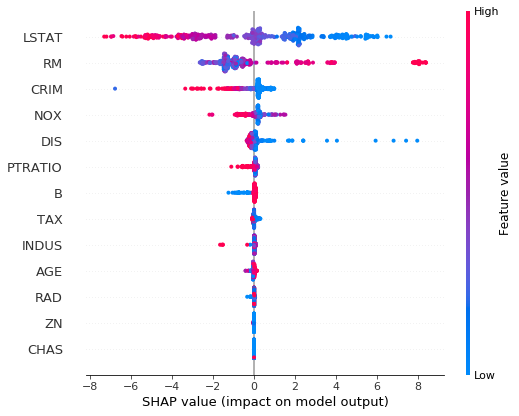

In [16]:
shap.summary_plot(shap_values, X_boston)

Anche questo grafico rappresenta il dato del precedente, mostrando però anche la 'varianza' di ogni feature, ovvero quanto una feature possa, a seconda del sample, spingere in una direzione o nell'altra la predizione anche a seconda del suo valore.
Notare come il campo DIS sia importante solo quando il valore è molto basso, mentre LSTAT è importante sempre.

## Partial dependency plot

Proviamo ad applicare il partial dependency plot sui dati precedenti per le feature più influenti.

<Figure size 1440x864 with 0 Axes>

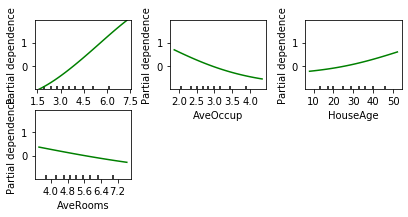

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets.california_housing import fetch_california_housing


cal_housing = fetch_california_housing()

X, y = cal_housing.data, cal_housing.target
names = cal_housing.feature_names
y -= y.mean()

est = MLPRegressor(activation='logistic')
est.fit(X, y)
features = [0, 5, 1, 2]
fig = plt.figure(figsize=(20, 12))
plot_partial_dependence(est, X, features, feature_names=names,
                        n_jobs=3, grid_resolution=50)


## Lime

Vediamo l'applicazione di Lime nella predizione di un dataset di immagini di facce, dalle quali cerchiamo di predire se si tratta di dev o no.

In [18]:
from skimage.color import gray2rgb, rgb2gray
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from lime.wrappers.scikit_image import SegmentationAlgorithm
from lime.lime_image import LimeImageExplainer

final_shape = (150, 120)
images = []
target = []

with open('./people.json') as input:
    glasses = json.load(input)

for file in os.listdir('./pics'):
    raw_image = io.imread(os.path.join(os.getcwd(), 'pics', file))[:,:,:3]
    smaller = transform.resize(raw_image, final_shape)
    images.append(smaller)
    name = file.split('.')[0]
    y = glasses.get(name)
    target.append(y)

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('PCA', PCA(10)),
    ('XGBoost', GradientBoostingClassifier(random_state=15022018))])

from sklearn.model_selection import train_test_split

explainer = LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

X_train, X_test, y_train, y_test = train_test_split(images, target, train_size=0.70)

simple_rf_pipeline.fit(X_train, y_train)
simple_rf_pipeline.score(X_test, y_test)

0.7272727272727273

100% |########################################################################|


Text(0.5, 1.0, 'Positive/Negative Regions for 1')

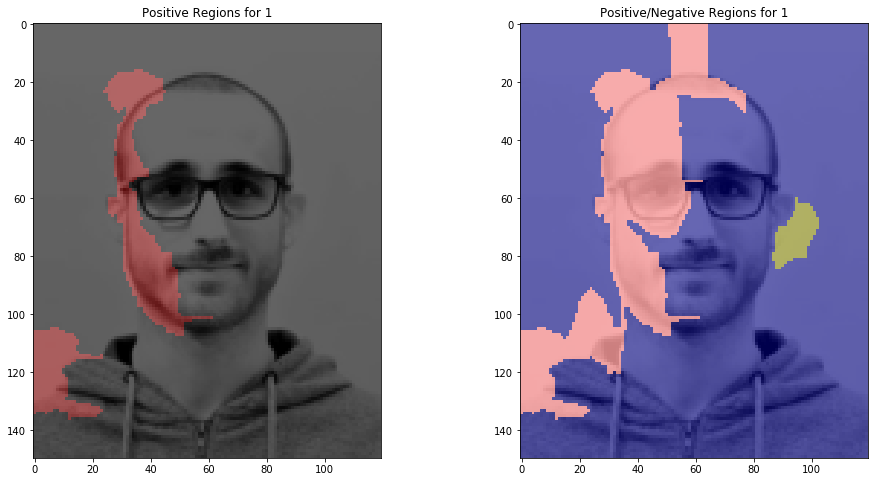

In [19]:
image_idx = 8

explanation = explainer.explain_instance(images[image_idx], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

from skimage.color import label2rgb

temp, mask = explanation.get_image_and_mask(target[image_idx], positive_only=True, num_features=2, hide_rest=False)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 8))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(target[image_idx],))
temp, mask = explanation.get_image_and_mask(target[image_idx], positive_only=False, num_features=6, hide_rest=False)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(target[image_idx]))